# Demonstration of accessing PyFLEXTRKR MCS tracking outputs

This notebook demonstrates how to access and perform simple analysis on the MCS tracking outputs from PyFLEXTRKR. It gives example code of the basic methods of loading the data using `xarray`, for both the tracks data and the HEALPix pixel-level data, as well as linking the two together. Some simple analysis is done.

The example largely follows that developed by Mark Muetzelfeldt, with updates to the pixel-level data in HEALPix Zarr stores.

* Authors:
- Zhe Feng (zhe.feng@pnnl.gov)
- Mark Muetzelfeldt (mark.muetzelfeldt@reading.ac.uk)

### Track statistics files

The MCS tracks statistics dataset are NetCDF4 files. These are laid out as 1D, 2D and 3D arrays of data, with the main coordinate being `tracks`, and variable length data stored in a fixed length array (using a maximum duration of 400, equivalent to an MCS that last for 400 hr). A consequence of this is that all the data over the duration of the length of a given MCS will be NANs or similar, and so the compression ratio of files on disk is very high. Hence, even though a file for a given year is only approximately 500MB on disk, its size in memory will be far larger. Fully loading one year using `xr.load_dataset` uses approximately 16G of memory. It is therefore sensible to use `xr.open_dataset` or `xr.open_mfdataset`, which access the dataset's metadata but do not load its data until they are needed.

Note, the compression level of a field can be seen from `xarray.Dataset`: `dstracks.area.encoding`. The tracks dataset is compressed using compression level 4.

### Pixel-level files

The pixel-level files are HEALPix format Zarr store files. The OLR (`rlut`) and precipitation (`pr`) data are part of the model catalog, while the MCS mask data (`mcs_mask_hp(x)_`) is remapped from lat/lon grid used in PyFLEXTRKR during tracking. The MCS mask data is being added to the catalog.

### Using `xarray` to access data

`xarray` is a convenient way of loading NetCDF or Zarr files in Python. Fields can generally be manipulated using `xarray` methods or by loading the values a `numpy` arrays and manipulating those. This notebook requires having the following Python packages correctly installed (using e.g. `conda`). 

In [1]:
# from pathlib import Path
import cftime
import cartopy.crs as ccrs
import cartopy.geodesic
import cartopy.feature as cf
import dask
from IPython.display import clear_output
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
import pandas as pd
import xarray as xr
import easygems.healpix as egh
import intake
from pyflextrkr.smooth_trajectory import smooth_trajectory

mpl.rcParams['figure.dpi'] = 72  # Set figure resolution to reduce file size
# Use for .mp4 video:
# plt.rcParams["animation.html"] = "html5"
# Use for javascript animation:
plt.rcParams["animation.html"] = "jshtml"

### Load the catalog
We have one data catalog for the global hackathon, listing our datasets.
But as we have multiple hosting sites, which have some datasets available locally and can access other datasets remotely, the best way to access data may be dependent on the location **where analysis code is executed**.
To solve this issue, we have one sub-catalog per hackathon node (the site where analysis code is executed), and an additional `online` catalog, which is available from the public internet. Here's how you can see our currently available sub-catalogs:

In [2]:
list(intake.open_catalog("https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml"))

['EU', 'NCAR', 'NERSC', 'UK', 'online']

In [3]:
# Load the NERSC catalog
current_location = "NERSC"
cat = intake.open_catalog("https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml")[current_location]

In [4]:
list(cat)

['ERA5',
 'JRA3Q',
 'MERRA2',
 'icon_d3hp003',
 'icon_ngc4008',
 'scream2D_hrly',
 'scream_lnd',
 'scream_ne120',
 'um_Africa_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_CTC_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_SAmer_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_SEA_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_glm_n1280_CoMA9',
 'um_glm_n1280_GAL9',
 'um_glm_n2560_RAL3p3']

### Pick a Data Set
Use `.describe()` on a dateset to see the other parameter options (we use `pandas` just for concise output formatting)

In [5]:
pd.DataFrame(cat["scream2D_hrly"].describe()["user_parameters"])

name                     description type  \
0  zoom  zoom resolution of the dataset  int   

                              allowed  default  
0  [10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]        2

### Load HEALPix Data into a DataSet
We will use `zoom` level 9 [(~12km)](https://easy.gems.dkrz.de/Processing/healpix/index.html#healpix-spatial-resolution) that contains hourly OLR & precipitation, which was used in the MCS tracking.

In [6]:
dshp = cat["scream2D_hrly"](zoom=9).to_dask() 
dshp


/global/common/software/m1867/python/pyflex-dev/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


<xarray.Dataset> Size: 238GB
Dimensions:  (crs: 0, time: 9457, cell: 3145728)
Coordinates:
  * crs      (crs) float64 0B 
  * time     (time) object 76kB 2019-08-01 00:00:00 ... 2020-09-01 00:00:00
Dimensions without coordinates: cell
Data variables:
    pr       (time, cell) float32 119GB dask.array<chunksize=(24, 262144), meta=np.ndarray>
    rlut     (time, cell) float32 119GB dask.array<chunksize=(24, 262144), meta=np.ndarray>
Attributes: (12/22)
    Conventions:                  CF-1.8
    atm_initial_conditions_file:  /lustre/orion/cli115/world-shared/e3sm/inpu...
    averaging_frequency:          1
    averaging_frequency_units:    nhours
    averaging_type:               INSTANT
    case:                         cess-control.ne1024pg2_ne1024pg2.F2010-SCRE...
    ...                           ...
    product:                      model-output
    realm:                        atmos
    run_t0:                       2019-08-01-00000
    source:                       E3SM Atmosphere Model (EAMxx)
    topography_file:              /lustre/orion/cli115/world-shared/e3sm/inpu...
    username:                     noel

### Load MCS Tracking Data

In [7]:
# MCS data (these may eventually be in the catalog)
maskdir = "/global/cfs/cdirs/m4581/gsharing/hackathon/tracking/mcs/scream/scream2D_hrly_tracks_hp9_v1.zarr"
statsdir = "/global/cfs/cdirs/m4581/gsharing/hackathon/tracking/mcs/scream/stats/"
# MCS track statistics file
stats_file = f"{statsdir}mcs_tracks_final_20190901.0000_20200901.0000.nc"
stats_file

'/global/cfs/cdirs/m4581/gsharing/hackathon/tracking/mcs/scream/stats/mcs_tracks_final_20190901.0000_20200901.0000.nc'

In [8]:
# chunks_tracks = {'tracks': 1000, 'times': 400}
chunks_tracks = None

# Open the dataset
dstracks = xr.open_dataset(
    stats_file, 
    chunks=chunks_tracks,
    mask_and_scale=True)

# # Each seperate file for each year defines its own index for tracks. Re-index with a global index.
# dstracks["tracks"] = np.arange(0, dstracks.dims["tracks"], 1, dtype=int)

In [9]:
dstracks.chunks

Frozen({})

In [10]:
# # Check if the dataset uses dask
# print(f"Dataset uses dask: {dstracks.chunks is not None}")

# # Check if variables are dask arrays
# for var_name in list(dstracks.data_vars)[:]:  # First 3 variables as example
#     print(f"Variable {var_name} is dask array: {isinstance(dstracks[var_name].data, dask.array.Array)}")

In [11]:
# The times have a small offset from the exact times -- e.g. 34500 ns off. Correct this.
# This mostly applies to the satellite data
def round_times_to_nearest_second(dstracks, fields):
    def remove_time_incaccuracy(t):
        # To make this an array operation, you have to use the ns version of datetime64, like so:
        return (np.round(t.astype(int) / 1e9) * 1e9).astype("datetime64[ns]")

    for field in fields:
        dstracks[field].load()
        tmask = ~np.isnan(dstracks[field].values)
        dstracks[field].values[tmask] = remove_time_incaccuracy(
            dstracks[field].values[tmask]
        )

In [12]:
round_times_to_nearest_second(dstracks, ['base_time', 'start_basetime', 'end_basetime'])

In [13]:
dstracks

<xarray.Dataset> Size: 33GB
Dimensions:                  (tracks: 52113, times: 400, mergers: 50, nmaxpf: 3)
Coordinates:
  * tracks                   (tracks) int64 417kB 0 1 2 3 ... 52110 52111 52112
  * times                    (times) int64 3kB 0 1 2 3 4 ... 395 396 397 398 399
  * mergers                  (mergers) int64 400B 0 1 2 3 4 5 ... 45 46 47 48 49
  * nmaxpf                   (nmaxpf) int64 24B 0 1 2
Data variables: (12/61)
    track_duration           (tracks) int32 208kB ...
    start_status             (tracks) float64 417kB ...
    end_status               (tracks) float64 417kB ...
    start_basetime           (tracks) datetime64[ns] 417kB 2019-09-01 ... 202...
    end_basetime             (tracks) datetime64[ns] 417kB 2019-09-01T18:00:0...
    start_split_cloudnumber  (tracks) float64 417kB ...
    ...                       ...
    pf_mcsstatus             (tracks, times) float64 167MB ...
    movement_distance        (tracks, times) float32 83MB ...
    movement_speed           (tracks, times) float32 83MB ...
    movement_theta           (tracks, times) float32 83MB ...
    movement_distance_x      (tracks, times) float32 83MB ...
    movement_distance_y      (tracks, times) float32 83MB ...
Attributes: (12/21)
    Title:                        Statistics of each MCS track
    Institution:                  Pacific Northwest National Laboratory
    Contact:                      Zhe Feng, zhe.feng@pnnl.gov
    Created_on:                   Sun Apr 13 21:03:31 2025
    startdate:                    20190901.0000
    enddate:                      20200901.0000
    ...                           ...
    MCS_PF_majoraxis_thresh:      0
    MCS_PF_duration_thresh:       4
    PF_PF_min_majoraxis_thresh:   20
    mcs_min_rainvol_thresh:       20000
    mcs_volrain_duration_thresh:  1.0
    max_speed_thresh:             50

In [14]:
# Note, 'NaT' means nan (track does not exist at those times)
dstracks.base_time

<xarray.DataArray 'base_time' (tracks: 52113, times: 400)> Size: 167MB
array([['2019-09-01T00:00:00.000000000', '2019-09-01T01:00:00.000000000',
        '2019-09-01T02:00:00.000000000', ...,
                                  'NaT',                           'NaT',
                                  'NaT'],
       ['2019-09-01T00:00:00.000000000', '2019-09-01T01:00:00.000000000',
        '2019-09-01T02:00:00.000000000', ...,
                                  'NaT',                           'NaT',
                                  'NaT'],
       ['2019-09-01T00:00:00.000000000', '2019-09-01T01:00:00.000000000',
        '2019-09-01T02:00:00.000000000', ...,
                                  'NaT',                           'NaT',
                                  'NaT'],
       ...,
       ['2020-08-31T19:00:00.000000000', '2020-08-31T20:00:00.000000000',
        '2020-08-31T21:00:00.000000000', ...,
                                  'NaT',                           'NaT',
                                  'NaT'],
       ['2020-08-31T20:00:00.000000000', '2020-08-31T21:00:00.000000000',
        '2020-08-31T22:00:00.000000000', ...,
                                  'NaT',                           'NaT',
                                  'NaT'],
       ['2020-08-31T20:00:00.000000000', '2020-08-31T21:00:00.000000000',
        '2020-08-31T22:00:00.000000000', ...,
                                  'NaT',                           'NaT',
                                  'NaT']], dtype='datetime64[ns]')
Coordinates:
  * tracks   (tracks) int64 417kB 0 1 2 3 4 5 ... 52108 52109 52110 52111 52112
  * times    (times) int64 3kB 0 1 2 3 4 5 6 7 ... 393 394 395 396 397 398 399
Attributes:
    long_name:  Epoch time of a feature

In [15]:
# Values can be accessed as a `numpy` array:
dstracks.ccs_area.values

array([[1209400.,  689200., 1902000., ...,      nan,      nan,      nan],
       [ 704400.,  667300.,  744000., ...,      nan,      nan,      nan],
       [ 588200.,  495000.,  287000., ...,      nan,      nan,      nan],
       ...,
       [   3300.,   25300.,   52500., ...,      nan,      nan,      nan],
       [ 381300.,  402900.,  280000., ...,      nan,      nan,      nan],
       [  53000.,   50400.,   54300., ...,      nan,      nan,      nan]],
      dtype=float32)

In [16]:
# Compression level info:
dstracks.ccs_area.encoding

{'dtype': dtype('float32'),
 'zlib': True,
 'szip': False,
 'zstd': False,
 'bzip2': False,
 'blosc': False,
 'shuffle': True,
 'complevel': 4,
 'fletcher32': False,
 'contiguous': False,
 'chunksizes': (1, 400),
 'preferred_chunks': {'tracks': 1, 'times': 400},
 'source': '/global/cfs/cdirs/m4581/gsharing/hackathon/tracking/mcs/scream/stats/mcs_tracks_final_20190901.0000_20200901.0000.nc',
 'original_shape': (52113, 400),
 '_FillValue': np.float32(nan)}

### Selecting tracks

In [17]:
# A single track can be selected from its track number:
track = dstracks.sel(tracks=234)
track

<xarray.Dataset> Size: 631kB
Dimensions:                  (times: 400, mergers: 50, nmaxpf: 3)
Coordinates:
    tracks                   int64 8B 234
  * times                    (times) int64 3kB 0 1 2 3 4 ... 395 396 397 398 399
  * mergers                  (mergers) int64 400B 0 1 2 3 4 5 ... 45 46 47 48 49
  * nmaxpf                   (nmaxpf) int64 24B 0 1 2
Data variables: (12/61)
    track_duration           int32 4B ...
    start_status             float64 8B ...
    end_status               float64 8B ...
    start_basetime           datetime64[ns] 8B 2019-09-02T08:00:00
    end_basetime             datetime64[ns] 8B 2019-09-03T23:00:00
    start_split_cloudnumber  float64 8B ...
    ...                       ...
    pf_mcsstatus             (times) float64 3kB ...
    movement_distance        (times) float32 2kB ...
    movement_speed           (times) float32 2kB ...
    movement_theta           (times) float32 2kB ...
    movement_distance_x      (times) float32 2kB ...
    movement_distance_y      (times) float32 2kB ...
Attributes: (12/21)
    Title:                        Statistics of each MCS track
    Institution:                  Pacific Northwest National Laboratory
    Contact:                      Zhe Feng, zhe.feng@pnnl.gov
    Created_on:                   Sun Apr 13 21:03:31 2025
    startdate:                    20190901.0000
    enddate:                      20200901.0000
    ...                           ...
    MCS_PF_majoraxis_thresh:      0
    MCS_PF_duration_thresh:       4
    PF_PF_min_majoraxis_thresh:   20
    mcs_min_rainvol_thresh:       20000
    mcs_volrain_duration_thresh:  1.0
    max_speed_thresh:             50

In [18]:
# You might want to select tracks based on e.g. the time at which they are active:
datetime = pd.Timestamp('2020-02-01 12:00').to_numpy()
# `isel` selects on index. The expression on the RHS collapses the 2D field of `base_time` into a 
# 1D boolean field that is true if *any* base_time for a given track matches `datetime`.
dstracks_at_time = dstracks.isel(
     tracks=(dstracks.base_time.values == datetime).any(axis=1)
)
dstracks_at_time

<xarray.Dataset> Size: 63MB
Dimensions:                  (tracks: 100, times: 400, mergers: 50, nmaxpf: 3)
Coordinates:
  * tracks                   (tracks) int64 800B 20832 21069 ... 21446 21447
  * times                    (times) int64 3kB 0 1 2 3 4 ... 395 396 397 398 399
  * mergers                  (mergers) int64 400B 0 1 2 3 4 5 ... 45 46 47 48 49
  * nmaxpf                   (nmaxpf) int64 24B 0 1 2
Data variables: (12/61)
    track_duration           (tracks) int32 400B ...
    start_status             (tracks) float64 800B ...
    end_status               (tracks) float64 800B ...
    start_basetime           (tracks) datetime64[ns] 800B 2020-01-27T21:00:00...
    end_basetime             (tracks) datetime64[ns] 800B 2020-02-01T19:00:00...
    start_split_cloudnumber  (tracks) float64 800B ...
    ...                       ...
    pf_mcsstatus             (tracks, times) float64 320kB ...
    movement_distance        (tracks, times) float32 160kB ...
    movement_speed           (tracks, times) float32 160kB ...
    movement_theta           (tracks, times) float32 160kB ...
    movement_distance_x      (tracks, times) float32 160kB ...
    movement_distance_y      (tracks, times) float32 160kB ...
Attributes: (12/21)
    Title:                        Statistics of each MCS track
    Institution:                  Pacific Northwest National Laboratory
    Contact:                      Zhe Feng, zhe.feng@pnnl.gov
    Created_on:                   Sun Apr 13 21:03:31 2025
    startdate:                    20190901.0000
    enddate:                      20200901.0000
    ...                           ...
    MCS_PF_majoraxis_thresh:      0
    MCS_PF_duration_thresh:       4
    PF_PF_min_majoraxis_thresh:   20
    mcs_min_rainvol_thresh:       20000
    mcs_volrain_duration_thresh:  1.0
    max_speed_thresh:             50

In [19]:
# Or access tracks based on their location:
# N.B. force a load of meanlat.
dstracks.meanlat.load()
# This suppresses a warning about chunk sizes.
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    dstracks_tropical = dstracks.isel(
        tracks=((dstracks.meanlat.values > -20) & (dstracks.meanlat.values < 20)).any(axis=1)
    )
dstracks_tropical

<xarray.Dataset> Size: 21GB
Dimensions:                  (tracks: 34165, times: 400, mergers: 50, nmaxpf: 3)
Coordinates:
  * tracks                   (tracks) int64 273kB 1 4 5 6 ... 52110 52111 52112
  * times                    (times) int64 3kB 0 1 2 3 4 ... 395 396 397 398 399
  * mergers                  (mergers) int64 400B 0 1 2 3 4 5 ... 45 46 47 48 49
  * nmaxpf                   (nmaxpf) int64 24B 0 1 2
Data variables: (12/61)
    track_duration           (tracks) int32 137kB ...
    start_status             (tracks) float64 273kB ...
    end_status               (tracks) float64 273kB ...
    start_basetime           (tracks) datetime64[ns] 273kB 2019-09-01 ... 202...
    end_basetime             (tracks) datetime64[ns] 273kB 2019-09-13T11:00:0...
    start_split_cloudnumber  (tracks) float64 273kB ...
    ...                       ...
    pf_mcsstatus             (tracks, times) float64 109MB ...
    movement_distance        (tracks, times) float32 55MB ...
    movement_speed           (tracks, times) float32 55MB ...
    movement_theta           (tracks, times) float32 55MB ...
    movement_distance_x      (tracks, times) float32 55MB ...
    movement_distance_y      (tracks, times) float32 55MB ...
Attributes: (12/21)
    Title:                        Statistics of each MCS track
    Institution:                  Pacific Northwest National Laboratory
    Contact:                      Zhe Feng, zhe.feng@pnnl.gov
    Created_on:                   Sun Apr 13 21:03:31 2025
    startdate:                    20190901.0000
    enddate:                      20200901.0000
    ...                           ...
    MCS_PF_majoraxis_thresh:      0
    MCS_PF_duration_thresh:       4
    PF_PF_min_majoraxis_thresh:   20
    mcs_min_rainvol_thresh:       20000
    mcs_volrain_duration_thresh:  1.0
    max_speed_thresh:             50

In [20]:
# Each track can then be looped over using e.g.:
for track_id in dstracks_at_time.tracks.values[:10]:  # Just get first 10.
    track = dstracks_at_time.sel(tracks=track_id)
    print(f"Track ID: {track.tracks.values.item()}, duration: {track.track_duration.values.item()}")

Track ID: 20832, duration: 119
Track ID: 21069, duration: 69
Track ID: 21085, duration: 145
Track ID: 21099, duration: 68
Track ID: 21166, duration: 62
Track ID: 21199, duration: 64
Track ID: 21205, duration: 69
Track ID: 21210, duration: 42
Track ID: 21217, duration: 85
Track ID: 21221, duration: 79


### Individual track properties

In [21]:
# Select a track.
track = dstracks.sel(tracks=2001)
track

<xarray.Dataset> Size: 631kB
Dimensions:                  (times: 400, mergers: 50, nmaxpf: 3)
Coordinates:
    tracks                   int64 8B 2001
  * times                    (times) int64 3kB 0 1 2 3 4 ... 395 396 397 398 399
  * mergers                  (mergers) int64 400B 0 1 2 3 4 5 ... 45 46 47 48 49
  * nmaxpf                   (nmaxpf) int64 24B 0 1 2
Data variables: (12/61)
    track_duration           int32 4B ...
    start_status             float64 8B ...
    end_status               float64 8B ...
    start_basetime           datetime64[ns] 8B 2019-09-17T01:00:00
    end_basetime             datetime64[ns] 8B 2019-09-18T03:00:00
    start_split_cloudnumber  float64 8B ...
    ...                       ...
    pf_mcsstatus             (times) float64 3kB ...
    movement_distance        (times) float32 2kB ...
    movement_speed           (times) float32 2kB ...
    movement_theta           (times) float32 2kB ...
    movement_distance_x      (times) float32 2kB ...
    movement_distance_y      (times) float32 2kB ...
Attributes: (12/21)
    Title:                        Statistics of each MCS track
    Institution:                  Pacific Northwest National Laboratory
    Contact:                      Zhe Feng, zhe.feng@pnnl.gov
    Created_on:                   Sun Apr 13 21:03:31 2025
    startdate:                    20190901.0000
    enddate:                      20200901.0000
    ...                           ...
    MCS_PF_majoraxis_thresh:      0
    MCS_PF_duration_thresh:       4
    PF_PF_min_majoraxis_thresh:   20
    mcs_min_rainvol_thresh:       20000
    mcs_volrain_duration_thresh:  1.0
    max_speed_thresh:             50

In [22]:
# Access some of the track's properties:
# Scalars can be accessed using:
duration = track.track_duration.values.item()  # `.values.item()` unpacks the value into an int (in this case).
print(f'track_duration: {duration}')
# For times, it is useful to convert from a np.datetime64[ns] to a pandas Timestamp object or native datetime object:
start_basetime = pd.Timestamp(track.start_basetime.values.item()).to_pydatetime()
print(f'start_basetime: {start_basetime}')

# Lifetime values can be accessed:
# Note, e.g. area values are nan after the duration of the track:
print(f'area (full): {track.area.values}')
# Slice based on duration:
print(f'area (sliced): {track.area.values[:duration]}')

track_duration: 27
start_basetime: 2019-09-17 01:00:00
area (full): [7.4000e+03 1.3900e+04 1.7700e+04 5.5400e+04 9.1900e+04 1.4080e+05
 1.7750e+05 2.1500e+05 2.8800e+05 3.5320e+05 4.0140e+05 4.5130e+05
 5.0420e+05 6.4920e+05 6.2250e+05 1.0178e+06 1.4145e+06 1.0212e+06
 1.4063e+06 9.5510e+05 7.8290e+05 9.6880e+05 5.4550e+05 5.0100e+05
 4.5750e+05 1.9970e+05 1.3000e+03        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan      

In [23]:
# Plot the MCS cloud shield area time evolution:
# track.ccs_area.plot()

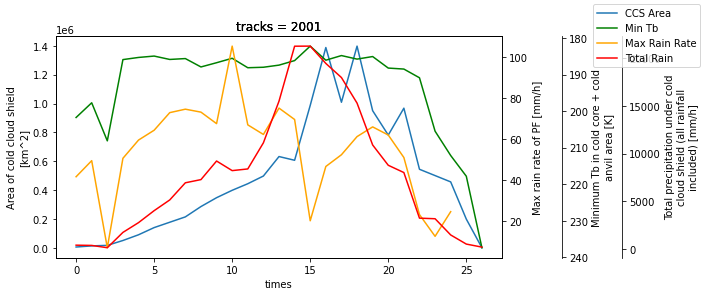

In [24]:
# Plot multiple variables for this track

fig, ax1 = plt.subplots(figsize=(8, 4))
track.ccs_area.plot.line(ax=ax1, label='CCS Area')

ax2 = ax1.twinx()
track.corecold_mintb.plot(ax=ax2, color='green', label='Min Tb')
ax2.spines['right'].set_position(('outward', 60))  # Move the third y-axis to the right
ax2.invert_yaxis()

ax3 = ax1.twinx()
track.pf_maxrainrate.isel(nmaxpf=0).plot(ax=ax3, color='orange', label='Max Rain Rate')
ax3.set_title('')

ax4 = ax1.twinx()
track.total_rain.plot(ax=ax4, color='red', label='Total Rain')
ax4.spines['right'].set_position(('outward', 120))  # Move the third y-axis to the right

fig.legend()

In [25]:
# mergers data are 2D fields (with -9999 indicating no values for merger number N):
track.merge_cloudnumber.values[:duration, :]

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [26]:
# Similarly for PF data (with nan indicating no value):
track.pf_rainrate.values[:duration, :]

array([[17.444798 ,        nan,        nan],
       [19.396593 ,        nan,        nan],
       [ 3.642234 ,        nan,        nan],
       [14.076908 , 16.538572 , 12.292864 ],
       [13.964077 , 18.771038 ,  3.4211912],
       [13.651215 , 14.239631 ,  4.3471093],
       [13.093377 ,  9.806874 , 20.726156 ],
       [14.3507805, 17.64512  ,  2.9985306],
       [12.434007 , 19.540384 , 12.185244 ],
       [12.988246 , 12.031208 , 15.784163 ],
       [12.270396 , 11.649001 , 12.509272 ],
       [10.951215 ,  8.072648 ,  9.52699  ],
       [ 9.013996 ,  6.1185   , 11.534578 ],
       [11.8789425, 10.324547 ,  6.064827 ],
       [10.708405 ,  7.544305 , 13.022357 ],
       [ 5.462044 ,  7.9311924,  7.762195 ],
       [13.009703 ,  9.892664 , 11.157013 ],
       [ 9.685159 ,  5.8382173,  9.085187 ],
       [10.451695 , 12.007852 ,  6.4264364],
       [10.569543 ,  7.5295744,  8.378777 ],
       [ 7.369762 ,  9.8796625,  9.1030855],
       [ 7.2170215,  7.7586746,  7.728683 ],
       [ 5

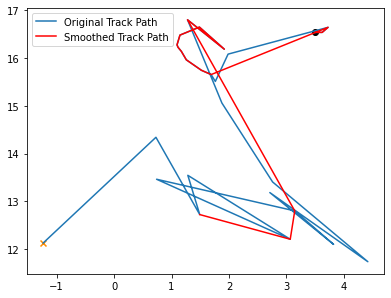

In [27]:
# A simple plot of the track's position can be made using:
plt.scatter(track.meanlon.values[0], track.meanlat.values[0], marker='o', color='k')  # Start point.
plt.scatter(track.meanlon.values[duration - 1], track.meanlat.values[duration - 1], marker='x', color='darkorange')  # End point.
# Plot the track's path:
plt.plot(track.meanlon.values, track.meanlat.values, label='Original Track Path')
# Smooth the trajectory using the `smooth_trajectory` function:
time_resolution = dstracks.attrs['time_resolution_hour']
max_speed_kmh = 100
lon_s, lat_s = smooth_trajectory(track.meanlon.values, track.meanlat.values, max_speed_kmh=max_speed_kmh, time_step_h=time_resolution)
plt.plot(lon_s, lat_s, color='red', label='Smoothed Track Path')
plt.legend()

In [28]:
def add_ccs_area_swath(ax, track, n_points=20):
    """Adds an area swath of the cold cloud system area, treating each CCS as a circle."""
    try:
        # N.B. these are optional dependencies.
        import shapely.geometry
        import shapely.ops
    except ImportError:
        print('shapely not installed')
        return
    duration = track.track_duration.values.item()
    time_indices = range(duration)
    
    # geoms will contain all the circles.
    geoms = []
    for i in time_indices:
        lon = track.meanlon.values[i]
        lat = track.meanlat.values[i]
        radius = np.sqrt(track.ccs_area.values[i] / np.pi) * 1e3
        circle_points = cartopy.geodesic.Geodesic().circle(
            lon=lon, lat=lat, radius=radius, n_samples=n_points, endpoint=False
        )
        geom = shapely.geometry.Polygon(circle_points)
        geoms.append(geom)
    # Combine all the circles into a CCS swath.
    full_geom = shapely.ops.unary_union(geoms)
    ax.add_geometries(
        (full_geom,),
        crs=cartopy.crs.PlateCarree(),
        facecolor="none",
        edgecolor="royalblue",
        linewidth=2,
    )

In [29]:
extent = track.meanlon.min().item() - 10, track.meanlon.max().item() + 10, track.meanlat.min().item() - 10, track.meanlat.max().item() + 10

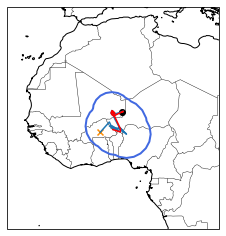

In [30]:
# Nicer figure using cartopy projections and showing a circle based on the CCS area.
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
fig.set_size_inches((8, 4))
ax.coastlines()
ax.add_feature(cf.BORDERS, linewidth=0.4)
ax.scatter(track.meanlon.values[0], track.meanlat.values[0], marker='o', color='k')
ax.scatter(track.meanlon.values[duration - 1], track.meanlat.values[duration - 1], marker='x', color='darkorange')
ax.plot(track.meanlon.values, track.meanlat.values)
ax.plot(lon_s, lat_s, color='red')
add_ccs_area_swath(ax, track)
extent = track.meanlon.min().item() - 20, track.meanlon.max().item() + 20, track.meanlat.min().item() - 20, track.meanlat.max().item() + 20
ax.set_extent(extent)

### Group properties of tracks

Group properties for lots of tracks can be easily calculated by accessing the fields on an `xarray.Dataset` that contains many tracks.

In [31]:
# mean track duration:
dstracks.track_duration.values.mean()

np.float64(18.04881699384031)

In [32]:
# Same thing using xarray:
dstracks.track_duration.mean().values.item()

18.04881699384031

In [33]:
# Tropical duration:
dstracks_tropical.track_duration.values.mean()

np.float64(18.115322698668226)

In [34]:
# Mean area for each track:
# `np.nanX` functions are useful for naturally dealing with the missing data.
mean_areas = np.nanmean(dstracks.ccs_area.values, axis=1)

(array([0.000e+00, 2.500e+01, 1.871e+03, 6.303e+03, 6.692e+03, 5.703e+03,
        4.438e+03, 3.576e+03, 2.807e+03, 2.204e+03, 1.860e+03, 1.530e+03,
        1.381e+03, 1.139e+03, 9.780e+02, 8.390e+02, 8.210e+02, 6.660e+02,
        6.260e+02, 5.390e+02, 4.520e+02, 4.470e+02, 4.320e+02, 3.830e+02,
        3.480e+02, 3.010e+02, 2.980e+02, 2.560e+02, 2.490e+02, 2.530e+02,
        2.150e+02, 1.950e+02, 1.890e+02, 1.810e+02, 1.600e+02, 1.550e+02,
        1.420e+02, 1.580e+02, 1.270e+02, 1.300e+02, 1.280e+02, 1.180e+02,
        9.800e+01, 9.200e+01, 9.100e+01, 1.040e+02, 1.050e+02, 8.000e+01,
        8.700e+01, 8.600e+01, 9.400e+01, 6.500e+01, 7.600e+01, 6.500e+01,
        4.800e+01, 6.100e+01, 6.400e+01, 5.100e+01, 5.500e+01, 6.300e+01,
        5.000e+01, 6.000e+01, 2.900e+01, 4.900e+01, 4.400e+01, 3.900e+01,
        4.900e+01, 4.100e+01, 4.200e+01, 3.300e+01, 3.500e+01, 2.700e+01,
        2.800e+01, 3.000e+01, 3.900e+01, 3.000e+01, 3.900e+01, 2.200e+01,
        3.000e+01, 2.300e+01, 3.300e+0

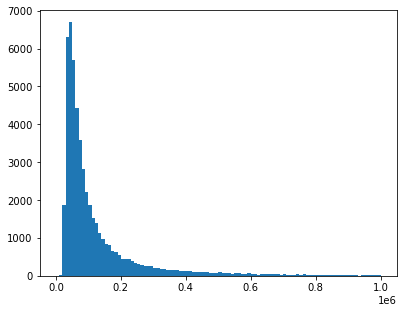

In [35]:
plt.hist(mean_areas, bins=np.linspace(0, 1e6, 101))

In [36]:
# Same thing using xarray:
xr_mean_areas = dstracks.ccs_area.mean(dim='times', skipna=True).values

In [37]:
(mean_areas == xr_mean_areas).all()

np.False_

## Accessing pixel-level data

Pixel-level data is stored separately from the MCS tracks data. These files contain the raw brightness temperature (tb) and precipitation fields, as well as a derived cloudnumber field, which is the area covered by the CCS and can be linked to a given track (see below).

In [38]:
# Read MCS mask data:
dsmask = xr.open_dataset(
    maskdir,
    chunks={},
    # mask_and_scale=False,
)
dsmask

<xarray.Dataset> Size: 219GB
Dimensions:   (cell: 3145728, time: 8713)
Coordinates:
  * cell      (cell) int64 25MB 0 1 2 3 4 ... 3145724 3145725 3145726 3145727
    crs       int64 8B ...
  * time      (time) datetime64[ns] 70kB 2019-09-01 ... 2020-09-01
Data variables:
    mcs_mask  (time, cell) float64 219GB dask.array<chunksize=(24, 262144), meta=np.ndarray>
Attributes: (12/14)
    Contact:                   Zhe Feng: zhe.feng@pnnl.gov
    Created_on:                Sun Apr 13 20:42:50 2025
    Institution:               Pacific Northwest National Laboratory
    Title:                     Remapped Pixel-level feature tracking data to ...
    linkpf:                    1
    minimum_cloud_area:        800
    ...                        ...
    pf_link_area_thresh:       648.0
    pf_smooth_window:          5
    tb_threshold_coldanvil:    241.0
    tb_threshold_core:         225.0
    tb_threshold_environment:  261.0
    tb_threshold_warmanvil:    261.0

In [39]:
# Convert time components from datasets to deal with different calendars
hp_times = [(t.year, t.month, t.day, t.hour) for t in dshp.time.values]
mask_times = [(pd.Timestamp(t).year, pd.Timestamp(t).month, 
               pd.Timestamp(t).day, pd.Timestamp(t).hour) 
              for t in dsmask.time.values]

# Find matching indices
matching_indices = [i for i, t in enumerate(hp_times) if t in set(mask_times)]
# Select using indices
dshp_subset = dshp.isel(time=matching_indices)
# Verify number of timestamps
print(f"Original HEALPix time count: {dshp.time.size}")
print(f"Matching times found: {len(matching_indices)}")
print(f"dsmask time count: {dsmask.time.size}")

Original HEALPix time count: 9457
Matching times found: 8713
dsmask time count: 8713


In [40]:
# Create a new dsmask with the time coordinate from dshp_subset
dsmask_ = dsmask.copy()

# Replace the time coordinate with the matching times from dshp_subset
# This must maintain the same order as in the original dsmask
dsmask_ = dsmask_.assign_coords(time=dshp_subset.time.values)

# Combine the datasets
ds = xr.merge([dshp_subset, dsmask_], combine_attrs='drop_conflicts')

# Rechunk the dataset to match the mask
ds = ds.chunk(dict(dsmask_.chunks))
ds

<xarray.Dataset> Size: 439GB
Dimensions:   (crs: 0, time: 8713, cell: 3145728)
Coordinates:
  * crs       (crs) float64 0B 
  * time      (time) object 70kB 2019-09-01 00:00:00 ... 2020-09-01 00:00:00
  * cell      (cell) int64 25MB 0 1 2 3 4 ... 3145724 3145725 3145726 3145727
Data variables:
    pr        (time, cell) float32 110GB dask.array<chunksize=(24, 262144), meta=np.ndarray>
    rlut      (time, cell) float32 110GB dask.array<chunksize=(24, 262144), meta=np.ndarray>
    mcs_mask  (time, cell) float64 219GB dask.array<chunksize=(24, 262144), meta=np.ndarray>
Attributes: (12/36)
    Conventions:                  CF-1.8
    atm_initial_conditions_file:  /lustre/orion/cli115/world-shared/e3sm/inpu...
    averaging_frequency:          1
    averaging_frequency_units:    nhours
    averaging_type:               INSTANT
    case:                         cess-control.ne1024pg2_ne1024pg2.F2010-SCRE...
    ...                           ...
    pf_link_area_thresh:          648.0
    pf_smooth_window:             5
    tb_threshold_coldanvil:       241.0
    tb_threshold_core:            225.0
    tb_threshold_environment:     261.0
    tb_threshold_warmanvil:       261.0

In [41]:
ds.rlut.attrs

{'long_name': 'LW_flux_up_at_model_top', 'units': 'W/m2'}

Text(0.5, 1.0, '2019-09-01 00:00')

<Figure size 460.8x345.6 with 0 Axes>

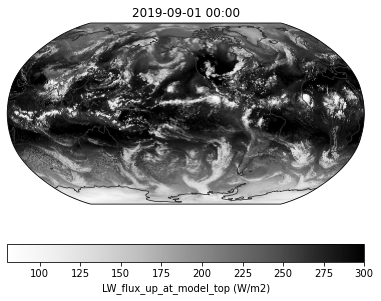

In [42]:
# Quick plot of global OLR
# im = egh.healpix_show(ds.isel(time=0).rlut, cmap='jet', dpi=150)
im = egh.healpix_show(ds.isel(time=0).rlut, vmin=80, vmax=300, cmap='Greys')
plt.colorbar(im, label=f"{ds.rlut.attrs['long_name']} ({ds.rlut.attrs['units']})", orientation='horizontal')
time_str = ds.time.isel(time=0).dt.strftime("%Y-%m-%d %H:%M").values.item()
plt.title(time_str)

In [43]:
# ds.time.isel(time=0).dt.strftime("%Y-%m-%d %H:%M").values.item()

In [44]:
# # Quick plot of global precipitation
# levels_pr = [0.5,1,2,4,8,16,32,64]
# cmap = mpl.colormaps.get_cmap('jet')
# norm = mpl.colors.BoundaryNorm(boundaries=levels_pr, ncolors=cmap.N)
# # Precipitation
# _pr = ds.isel(time=0).pr * 3600000  # Convert unit to mm/hr
# _pr = _pr.where(_pr >= np.min(levels_pr), np.nan)

# im = egh.healpix_show(_pr, norm=norm, cmap=cmap)
# plt.colorbar(im, label=f"{ds.pr.attrs['long_name']} (mm/h)", orientation='horizontal')
# time_str = ds.time.isel(time=0).dt.strftime("%Y-%m-%d %H:%M").values.item()
# plt.title(time_str)

## Linking tracks to pixel-level data

Every track has a corresponding track number in the pixel-level mask data. This can be used to link each track to its pixel-level data, using the timestamp and the track number. The timestamp can be used to determine which time step data to load, and the track number references the equivalent field in the HEALPix dataset (as shown in the figure above).

In [45]:
itrack = 2 # (Borneo)
# itrack = 17
# itrack = 40 # (Brazil)

# Select a tropical track from July 2019, that lasted more than buffer hours and less than 40.
dates = pd.DatetimeIndex(dstracks_tropical.start_basetime.values)  # These containers make it easy to select on year, month...
track = dstracks_tropical.isel(tracks=(
    (dates.year == 2020) & 
    (dates.month == 6) & 
    (dstracks_tropical.track_duration > 20) & 
    (dstracks_tropical.track_duration < 40)
)).isel(tracks=itrack)  # just select one track that meets criteria.
duration = track.track_duration.values.item()
duration

26

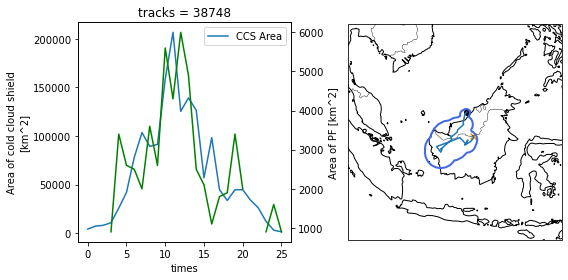

In [46]:
# Create a figure with 1 row and 2 columns
fig = plt.figure(figsize=(8, 4))

# Create left subplot (regular axis)
ax1 = fig.add_subplot(1, 2, 1)
track.ccs_area.plot(ax=ax1, label='CCS Area')
ax1b = ax1.twinx()
track.pf_area.isel(nmaxpf=0).plot(ax=ax1b, color='green', label='PF Area')
# ax1b.spines['right'].set_position(('outward', 60))  # Move the third y-axis to the right
# ax1b.invert_yaxis()
ax1b.set_title('')
ax1.legend()

# Create right subplot (with Cartopy projection)
# Use PlateCarree projection (equirectangular projection)
ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())

ax2.coastlines()
ax2.add_feature(cf.BORDERS, linewidth=0.4)

ax2.scatter(track.meanlon.values[0], track.meanlat.values[0], marker='o', color='k')
ax2.scatter(track.meanlon.values[duration - 1], track.meanlat.values[duration - 1], marker='x', color='darkorange')
ax2.plot(track.meanlon.values, track.meanlat.values)
add_ccs_area_swath(ax2, track)
buffer = 10
extent = track.meanlon.min().item() - buffer, track.meanlon.max().item() + buffer, track.meanlat.min().item() - buffer, track.meanlat.max().item() + buffer
ax2.set_extent(extent)

fig.tight_layout()
# fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # Make room for suptitle

In [47]:
def convert_to_cftime(datetime, calendar):
    """
    Convert a pandas.Timestamp object to a cftime object based on the calendar type.

    Args:
        datetime: pandas.Timestamp
            Timestamp object to convert.
        calendar: str
            Calendar type.

    Returns:
        cftime object.
    """
    if calendar == 'noleap':
        return cftime.DatetimeNoLeap(datetime.year, datetime.month, datetime.day, datetime.hour, datetime.minute)
    elif calendar == 'gregorian':
        return cftime.DatetimeGregorian(datetime.year, datetime.month, datetime.day, datetime.hour, datetime.minute)
    elif calendar == 'proleptic_gregorian':
        return cftime.DatetimeProlepticGregorian(datetime.year, datetime.month, datetime.day, datetime.hour, datetime.minute)
    elif calendar == 'standard':
        return cftime.DatetimeGregorian(datetime.year, datetime.month, datetime.day, datetime.hour, datetime.minute)
    elif calendar == '360_day':
        return cftime.Datetime360Day(datetime.year, datetime.month, datetime.day, datetime.hour, datetime.minute)
    else:
        raise ValueError(f"Unsupported calendar type: {calendar}")

In [48]:
# These can be used to work out which pixel-level data to locate the times.
calendar = ds['time'].dt.calendar

base_times = track.base_time.values[:duration]
track_dates = [convert_to_cftime(pd.Timestamp(d).to_pydatetime(), calendar) for d in base_times]
print(len(track_dates))
track_dates

26


[cftime.DatetimeNoLeap(2020, 6, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeNoLeap(2020, 6, 1, 1, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeNoLeap(2020, 6, 1, 2, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeNoLeap(2020, 6, 1, 3, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeNoLeap(2020, 6, 1, 4, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeNoLeap(2020, 6, 1, 5, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeNoLeap(2020, 6, 1, 6, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeNoLeap(2020, 6, 1, 7, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeNoLeap(2020, 6, 1, 8, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeNoLeap(2020, 6, 1, 9, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeNoLeap(2020, 6, 1, 10, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeNoLeap(2020, 6, 1, 11, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeNoLeap(2020, 6, 1, 12, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeNoLeap(2020, 6, 1, 13, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeNoLeap(2020, 6, 1, 14, 0, 0,

In [49]:
# Track number in the mask file is +1 offset to the track index in the stats file.
track_number = track.tracks + 1

In [50]:
# Increase the animation embed limit [MB]
mpl.rcParams['animation.embed_limit'] = 30

In [54]:
%%capture
# Prev line ensures figure not shown until animation.fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
# Set up a figure to use for the animation below.

margin_degree = 10
minlon = track.meanlon.values[:duration].min()
maxlon = track.meanlon.values[:duration].max()
minlat = track.meanlat.values[:duration].min()
maxlat = track.meanlat.values[:duration].max()
aspect = (maxlon - minlon + 2 * margin_degree) / (maxlat - minlat + 2 * margin_degree)
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
fig.set_size_inches((6, 6 / aspect))
fig.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95)

In [55]:
# Create an animation of the track, MCS, OLR, and precip.
def plot_track_link_pixel(i):
    try:
        print(f'{i + 1}/{duration}')
        # print(f'{i}/{duration}')
        ax.clear()

        ax.set_extent((minlon - margin_degree, maxlon + margin_degree, minlat - margin_degree, maxlat + margin_degree))
        ax.coastlines(zorder=3)
        ax.add_feature(cf.BORDERS, linewidth=0.4, zorder=3)

        date = track_dates[i]
        ax.set_title(date)
        # Subset the HEALPix dataset to the current date & time
        _ds = ds.sel(time=track_dates[i], method='nearest')

        # Colormaps
        cmap_pr = mpl.colormaps.get_cmap('jet')
        cmap_rlut = mpl.colormaps.get_cmap('Greys')
        levels_pr = [0.5,1,2,4,8,16,32,64]
        norm = mpl.colors.BoundaryNorm(boundaries=levels_pr, ncolors=cmap_pr.N)
        # Precipitation
        _pr = _ds.pr * 3600000  # Convert unit to mm/hr
        _pr = _pr.where(_pr >= np.min(levels_pr), np.nan)
        # Mask
        _mask = _ds.mcs_mask.load()
        _mask = _mask.where(_mask == track_number, 1, 0)
        Zm_mask = np.ma.masked_where(_mask == 0, _mask)
        # Colorfill OLR and precipitation
        im_rlut = egh.healpix_show(_ds.rlut, ax=ax, vmin=80, vmax=260, cmap=cmap_rlut, alpha=0.7, zorder=1)
        im_pr = egh.healpix_show(_pr, ax=ax, cmap=cmap_pr, norm=norm, alpha=0.9, zorder=1)
        im_mask = egh.healpix_show(Zm_mask, ax=ax, cmap='Reds', vmin=1, vmax=1.01, alpha=0.5, zorder=2)
        # Contour MCS mask (boundary)
        # im_mask = egh.healpix_contour(_mask, ax=ax, levels=[0.5], colors=['r'], linewidths=1, alpha=1)

        # Display track path.
        ax.scatter(track.meanlon.values[0], track.meanlat.values[0], marker='^', c='maroon', zorder=3)
        ax.scatter(track.meanlon.values[duration - 1], track.meanlat.values[duration - 1], marker='x', c='maroon', zorder=3)
        ax.scatter(track.meanlon.values[i], track.meanlat.values[i], marker='o', c='firebrick', zorder=3)
        ax.plot(track.meanlon.values, track.meanlat.values, 'r-', zorder=2)
        # clear_output(wait=True)

        return ax
    except Exception as e:
        print(f"Error in frame {i}: {str(e)}")

In [56]:
# Create animation with specific settings
anim = matplotlib.animation.FuncAnimation(
    fig, 
    plot_track_link_pixel, 
    frames=duration,  # Number of frames
    # frames=2,
    interval=500,
    blit=False,  # Set to False for complex plots with multiple elements
    cache_frame_data=False  # Disable caching to avoid memory issues
)
anim

1/26
1/26
2/26
3/26
4/26
5/26
6/26
7/26
8/26
9/26
10/26
11/26
12/26
13/26
14/26
15/26
16/26
17/26
18/26
19/26
20/26
21/26
22/26
23/26
24/26
25/26
26/26


* Track: red line with circle showing its centroid.
* MCS mask: red shading.
* OLR: grey filled.
* precipitation: color filled contours.